# AIR QUALITY

In [1]:
#establish connection
import os
import re
from sagemaker import get_execution_role

#define iam rle

role = get_execution_role()

## SET S3 BUCKET & UPLOAD LOCATION

In [124]:
#specify role and bucket
bucket = 'bucket-name'# s3 bucket where you will copy data and model artifacts
prefix = 'mra/air-quality' # place to upload training files within the bucket

In [160]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import sagemaker
import sagemaker.amazon.common as smac

import warnings
warnings.filterwarnings("ignore")

### Data Set Information:

#### The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 

#### This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. 

#### Attribute Information:

#### 0 Date	(DD/MM/YYYY) 
#### 1 Time	(HH.MM.SS) 
#### 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
#### 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
#### 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
#### 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
#### 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
#### 7 True hourly averaged NOx concentration in ppb (reference analyzer) 
#### 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
#### 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
#### 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
#### 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
#### 12 Temperature in Â°C	
#### 13 Relative Humidity (%) 
#### 14 AH Absolute Humidity 



##  DATA INGESTION

In [161]:
#download data file as csv
import boto3
import io

s3 = boto3.client('s3')

try:
    obj = s3.get_object(Bucket=bucket, Key='AirQualityUCI.csv')
    air = pd.read_csv(io.BytesIO(obj['Body'].read()),parse_dates=[['Date', 'Time']])
    print('Success: Data loaded into dataframe.')
    
except Exception as e:
    
    print('Data load error: ',e)


Success: Data loaded into dataframe.


In [162]:
#view for full screen
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)


## DATA INSPECTION

In [163]:
# print the shape of the data file
print("Datapoints in data sest",air.shape)

# show the top few rows
display("Top 5 rows",air.head())

Datapoints in data sest (9357, 14)


'Top 5 rows'

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [164]:
# Set Date time as Index
air.set_index('Date_Time', inplace=True)

In [165]:
#nformation of the data
print('\nData Information\n')
air.info()


# statistical description of the data object
display("Statistical Description of data",air.describe())


Data Information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(5), int64(8)
memory usage: 1023.4 KB


'Statistical Description of data'

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [166]:
# Renaming few columns
air.rename(columns={'T': 'Temparature', 'RH': 'Relative Humidity', 'AH': 'Absolute Humidity'}, inplace=True)
air.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'Temparature', 'Relative Humidity', 'Absolute Humidity'],
      dtype='object')

In [167]:
#check null values
print("Percentage missing data in each column")
pd.isnull(air).sum()

Percentage missing data in each column


CO(GT)               0
PT08.S1(CO)          0
NMHC(GT)             0
C6H6(GT)             0
PT08.S2(NMHC)        0
NOx(GT)              0
PT08.S3(NOx)         0
NO2(GT)              0
PT08.S4(NO2)         0
PT08.S5(O3)          0
Temparature          0
Relative Humidity    0
Absolute Humidity    0
dtype: int64

In [168]:
# Replace negative 200 value with mean of the column
air = air.replace(-200, np.nan)
print("Percentage missing data in each column \n",pd.isnull(air).sum())

Percentage missing data in each column 
 CO(GT)               1683
PT08.S1(CO)           366
NMHC(GT)             8443
C6H6(GT)              366
PT08.S2(NMHC)         366
NOx(GT)              1639
PT08.S3(NOx)          366
NO2(GT)              1642
PT08.S4(NO2)          366
PT08.S5(O3)           366
Temparature           366
Relative Humidity     366
Absolute Humidity     366
dtype: int64


In [169]:
#replace Null values with Mean

# Mean value of each column
#daf = daf.fillna(0)
print("Mean values to be imputed with:\n",air.mean())

# Use Mean as imputation method for remaining missing data
air = air.fillna(air.mean())
print("\nPercent missing data \n",pd.isnull(air).sum())

Mean values to be imputed with:
 CO(GT)                  2.152750
PT08.S1(CO)          1099.833166
NMHC(GT)              218.811816
C6H6(GT)               10.083105
PT08.S2(NMHC)         939.153376
NOx(GT)               246.896735
PT08.S3(NOx)          835.493605
NO2(GT)               113.091251
PT08.S4(NO2)         1456.264598
PT08.S5(O3)          1022.906128
Temparature            18.317829
Relative Humidity      49.234201
Absolute Humidity       1.025530
dtype: float64

Percent missing data 
 CO(GT)               0
PT08.S1(CO)          0
NMHC(GT)             0
C6H6(GT)             0
PT08.S2(NMHC)        0
NOx(GT)              0
PT08.S3(NOx)         0
NO2(GT)              0
PT08.S4(NO2)         0
PT08.S5(O3)          0
Temparature          0
Relative Humidity    0
Absolute Humidity    0
dtype: int64


In [170]:
air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temparature,Relative Humidity,Absolute Humidity
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.316068,212.791672,63.870229,7.302650,261.560236,193.426632,251.743954,43.920954,339.367559,390.612324,8.657639,16.974801,0.395835
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.200000,941.000000,218.811816,4.600000,743.000000,112.000000,666.000000,86.000000,1242.000000,742.000000,12.000000,36.600000,0.746100
50%,2.152750,1075.000000,218.811816,8.600000,923.000000,229.000000,818.000000,113.091251,1456.264598,983.000000,18.300000,49.234201,1.015400
75%,2.600000,1221.000000,218.811816,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


## DATA VISUALIZATION

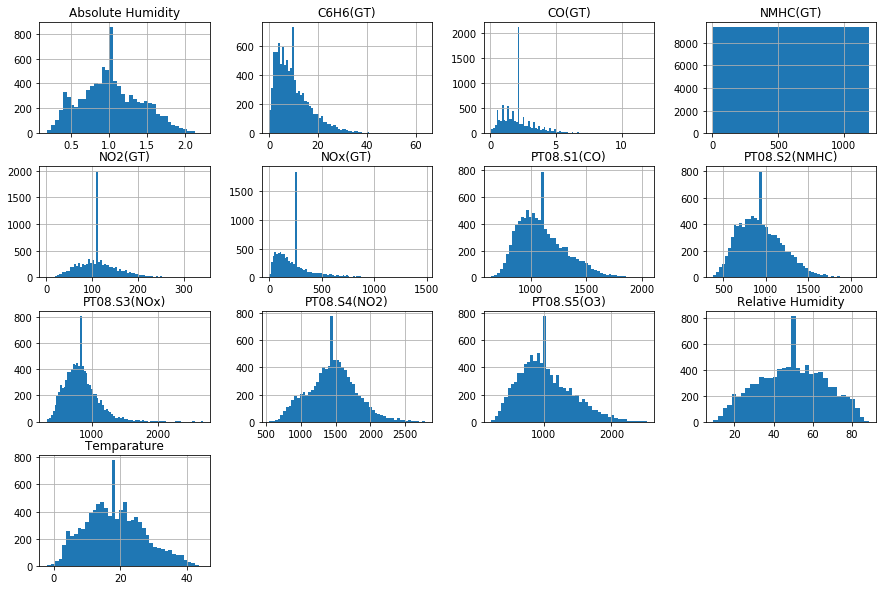

In [171]:
hist = air.hist(bins='auto',  figsize=(15, 10))

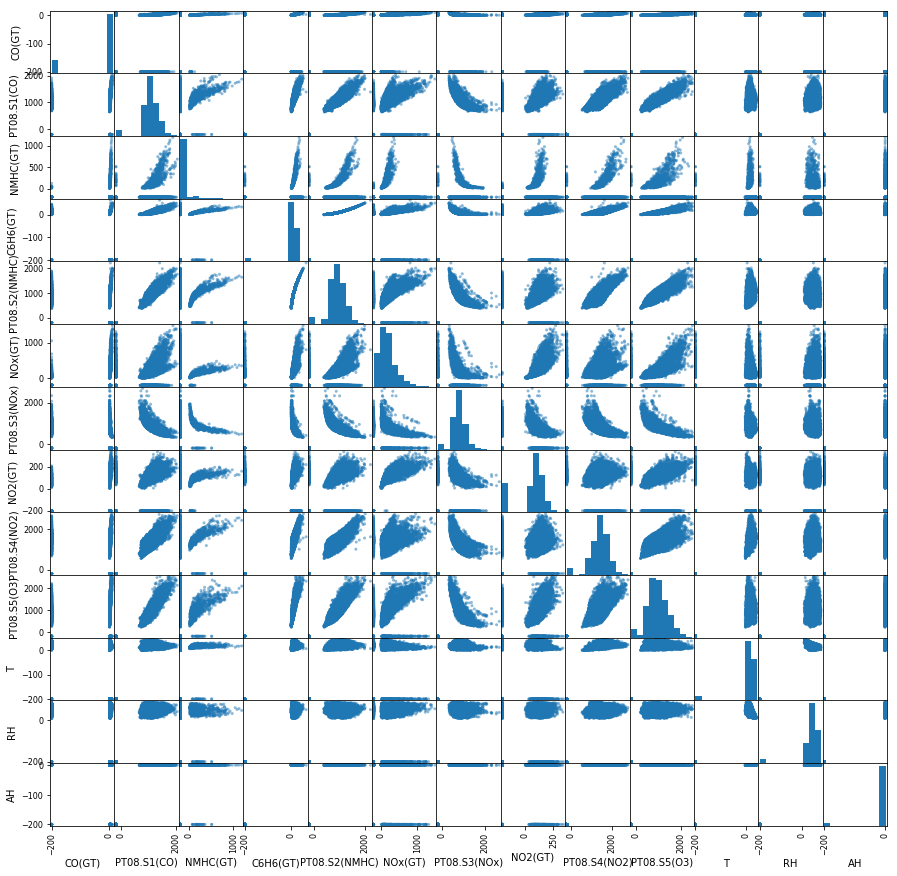

In [21]:
pd.plotting.scatter_matrix(air,figsize=(15, 15))
plt.show()

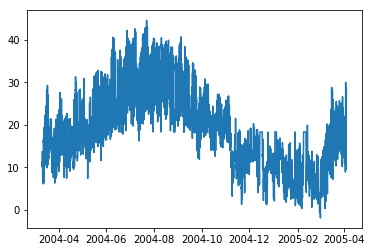

In [172]:
plt.plot(air['Temparature'],label ='Temparature')

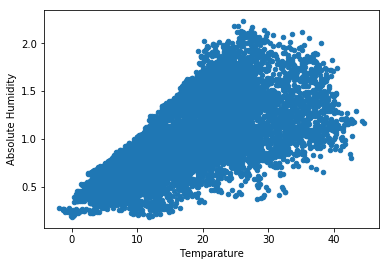

In [173]:
# percent change in rent vs percent change in population
air.plot(kind='scatter', x='Temparature', y='Absolute Humidity')

##  CORRELATION

Text(0.5,1,'Heatmap of Correlation between Features')

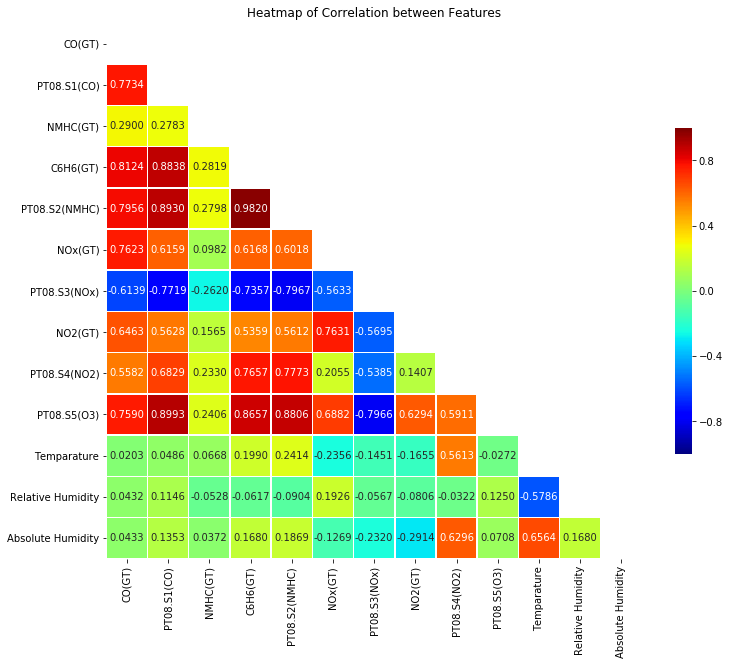

In [143]:
#Correlation of features
import seaborn as sns

corr=air.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))
# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='jet', vmax=1,vmin=-1, center=0,annot=True,fmt= '.4f',
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation between Features')

## PREDICTOR AND RESPONSE

### TEST TRAIN SPLIT

In [144]:
# Splitting the dataset into the Training set and Test set
#70% train 15% validation  15% test data
split_train = int(len(air)* 0.80)
split_test = int(len(air) * 0.9)

#train set
air_train_y = air['Temparature'][:split_train]
air_train_X = air.drop('Temparature',axis =1 ).iloc[:split_train,]

#validation set
air_val_y = air['Temparature'][split_train : split_test]
air_val_X = air.drop('Temparature',axis =1 ).iloc[split_train:split_test,]

#test set
air_test_y = air['Temparature'][split_test:]
air_test_X = air.drop('Temparature',axis =1 ).iloc[split_test:, ]

In [145]:
print("Length of training set", len(air_train_y))
print("Length of validation set", len(air_val_y))
print("Length of test set", len(air_test_y))

Length of training set 7485
Length of validation set 936
Length of test set 936


## FEATURE SELECTION

### Based on p -value

In [146]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(air_train_X, air_train_y)

print('Resulting Features with p value less than 0.05:')
print(result)

Add  Absolute Humidity              with p-value 0.0
Add  Relative Humidity              with p-value 0.0
Add  PT08.S4(NO2)                   with p-value 3.57935e-26
Add  PT08.S5(O3)                    with p-value 7.62959e-53
Add  PT08.S2(NMHC)                  with p-value 4.14146e-30
Add  C6H6(GT)                       with p-value 6.062e-30
Add  NO2(GT)                        with p-value 4.81161e-11
Add  CO(GT)                         with p-value 6.29443e-05
Add  NOx(GT)                        with p-value 0.0172162
Resulting Features with p value less than 0.05:
['Absolute Humidity', 'Relative Humidity', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'PT08.S2(NMHC)', 'C6H6(GT)', 'NO2(GT)', 'CO(GT)', 'NOx(GT)']


## USING OLS

In [86]:
#round 1
from scipy.stats import pearsonr
import statsmodels.formula.api as sm

y = air_train_y 
X = air_train_X.copy()

arr = np.ones([len(X),1]).astype(int)
X['Coeff'] = arr

#X = sm.add_constant(X)
#X = np.append ( arr = np.ones([152,1]).astype(int), values = mra_X, axis = 1)
regressor_OLS=sm.OLS(endog=y, exog=X).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temparature   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     8763.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        01:36:18   Log-Likelihood:                -16064.
No. Observations:                7485   AIC:                         3.215e+04
Df Residuals:                    7472   BIC:                         3.224e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
CO(GT)               -0.1889      0.042     -4.448      0.000      -0.272      -0.106
PT08.S1(CO)           0.0002      0.000      0.624      0.533      -0.000       0.001
NMHC(GT)             -0.0002      0.000     -0.601      0.548      -0.001       0.001
C6H6(GT)             -0.1848      0.022     -8.362      0.000      -0.228      -0.141
PT08.S2(NMHC)         0.0079      0.001     10.319      0.000       0.006       0.009
NOx(GT)               0.0007      0.000      2.276      0.023    9.55e-05       0.001
PT08.S3(NOx)         -0.0002      0.000     -0.693      0.488      -0.001       0.000
NO2(GT)               0.0068      0.001      5.590      0.000       0.004       0.009
PT08.S4(NO2)          0.0023      0.000      9.485      0.000       0.002       0.003
PT08.S5(O3)          -0.0034      0.000    -18.355      0.000      -0.004      -0.003
Relative Humidity    -0.3523      0.002   -184.004      0.000      -0.356      -0.349
Absolute Humidity    13.9765      0.121    115.764      0.000      13.740      14.213
Coeff                15.6791      0.678     23.136      0.000      14.351      17.008
==============================================================================
Omnibus:                     1190.280   Durbin-Watson:                   0.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3693.507
Skew:                           0.822   Prob(JB):                         0.00
Kurtosis:                       6.024   Cond. No.                     7.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feature ranking with recursive feature elimination.

In [89]:
# Using Linear Regression
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)


names =(air_train_X.columns.values)
y = air_train_y.as_matrix()

#use linear regression as the model
lr = LinearRegression()


#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(air_train_X,y)
 
#Results
print("Features sorted by their rank: \n")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
#print(rfe.ranking_)


Features sorted by their rank: 

[(1, 'Absolute Humidity'), (2, 'Relative Humidity'), (3, 'CO(GT)'), (4, 'C6H6(GT)'), (5, 'PT08.S2(NMHC)'), (6, 'NO2(GT)'), (7, 'PT08.S5(O3)'), (8, 'PT08.S4(NO2)'), (9, 'NOx(GT)'), (10, 'PT08.S1(CO)'), (11, 'NMHC(GT)'), (12, 'PT08.S3(NOx)')]


In [90]:
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False  True]
[ 3 10 11  4  5  9 12  6  8  7  2  1]


In [91]:
# Define dictionary to store our rankings
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier

## !conda install -y -c conda-forge xgboost

def feature_rank(X, y):
    
    # Create a function which stores the feature rankings to the ranks dictionary
    ranks = {}
   
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))
    
    # Names of all columns
    colnames = list(X.columns.values)
    
    # Randomized Lasso model
    rlasso = RandomizedLasso(alpha=0.04)
    rlasso.fit(X, y)
    ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
    
    # Linear Regression model    
    lr = LinearRegression(normalize=True)
    lr.fit(X, y)
    ranks["Linear Reg"] = ranking((np.abs(lr.coef_).ravel()), colnames)

    ##stop the search when only the last feature is left
    rfe= RFE(lr, n_features_to_select=1 )
    rfe.fit(X, y)
    ranks["Recurssive Feature Elimination"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Using Ridge 
    ridge = Ridge(alpha = 7)
    ridge.fit(X, y)
    ranks['Ridge Reg'] = ranking(np.abs(ridge.coef_).ravel(), colnames)

    # Using Lasso
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso Reg"] = ranking(np.abs(lasso.coef_).ravel(), colnames)
    
    # Using Random Forest 
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=50)
    rf.fit(X, y)
    ranks["Random Forest"] = ranking(rf.feature_importances_, colnames);
    
    # Using Xtreme Gradient Boost
    xgb = XGBClassifier()
    xgb.fit(X, y)
    ranks["Xtreme Gradient Boost"] = ranking(xgb.feature_importances_, colnames);
    
    #List of save the mean of ranking for each method
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    
    # Save the result in dataFrame
    df =pd.DataFrame.from_dict(ranks,orient='columns')
    df = df[['Lasso Reg','Linear Reg','Random Forest','Recurssive Feature Elimination','Ridge Reg',
             'rlasso/Stability','Xtreme Gradient Boost','Mean']]
    df  =(df.sort_values(['Mean'],ascending=False))
    return df


In [122]:
# Feature Ranking for DNF A
result = feature_rank(air_train_X,air_train_y)
print("Feature Ranking Using various Methods\n",)
result

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Feature Ranking Using various Methods



,Lasso Reg,Linear Reg,Random Forest,Recurssive Feature Elimination,Ridge Reg,rlasso/Stability,Xtreme Gradient Boost,Mean
Absolute Humidity,1.00,1.00,0.87,1.00,1.00,1.00,0.84,0.96
Relative Humidity,0.03,0.03,1.00,0.91,0.03,0.88,1.00,0.55
CO(GT),0.01,0.01,0.00,0.82,0.02,0.00,0.12,0.14
PT08.S4(NO2),0.00,0.00,0.01,0.36,0.00,0.11,0.38,0.12
C6H6(GT),0.01,0.01,0.00,0.73,0.01,0.00,0.00,0.11
NO2(GT),0.00,0.00,0.00,0.55,0.00,0.00,0.21,0.11
PT08.S2(NMHC),0.00,0.00,0.00,0.64,0.00,0.00,0.12,0.11
PT08.S5(O3),0.00,0.00,0.00,0.45,0.00,0.00,0.27,0.10
NOx(GT),0.00,0.00,0.00,0.27,0.00,0.00,0.23,0.07
PT08.S1(CO),0.00,0.00,0.00,0.18,0.00,0.00,0.26,0.06


### DATA CONVERSION & UPLOAD

In [148]:
#convert and upload train data into recordIO-wrapped protobuf format

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(air_train_X).astype('float32'), np.array(air_train_y).astype('float32'))
buf.seek(0)

0

In [149]:
key = 'linear_train_temparature'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
#print('uploaded training data location: {}'.format(s3_train_data))

In [150]:
#convert and upload validation data into recordIO format

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(air_val_X).astype('float32'), np.array(air_val_y).astype('float32'))
buf.seek(0)

0

In [151]:
key = 'linear_validation_temparature'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
#print('uploaded validation data location: {}'.format(s3_validation_data))

### TRAIN REGRESSION MODEL

In [99]:
#set container location

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [100]:
#mutilple linear regression
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sess)

In [102]:
air_train_X.shape

(7485, 12)

In [103]:
#optimize the hyperparameters

linear.set_hyperparameters(feature_dim=12,
                           normalize_data=False,
                           predictor_type='regressor',
                           mini_batch_size=50,)

In [104]:
#fit the linear model
linear.fit({'train': s3_train_data, 'validation': s3_validation_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-12-18-01-41-51-584


2018-12-18 01:41:51 Starting - Starting the training job...
2018-12-18 01:41:53 Starting - Launching requested ML instances......
2018-12-18 01:42:56 Starting - Preparing the instances for training...
2018-12-18 01:43:44 Downloading - Downloading input data
2018-12-18 01:43:44 Training - Downloading the training image....
Docker entrypoint called with argument(s): train
[12/18/2018 01:44:24 INFO 140241566426944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'nu


2018-12-18 01:44:23 Training - Training image download completed. Training in progress.#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.5232250447081239, "sum": 0.5232250447081239, "min": 0.5232250447081239}}, "EndTime": 1545097480.737857, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1545097480.73776}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.30872605815029786, "sum": 0.30872605815029786, "min": 0.30872605815029786}}, "EndTime": 1545097480.737996, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1545097480.737974}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.26228008869510366, "sum": 0.26228008869510366, "min": 0.26228008869510366}}, "EndTime": 1545097480.738066, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner",

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.43588713260305006, "sum": 0.43588713260305006, "min": 0.43588713260305006}}, "EndTime": 1545097486.763261, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1545097486.763202}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.44312648445167796, "sum": 0.44312648445167796, "min": 0.44312648445167796}}, "EndTime": 1545097486.763334, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1545097486.763322}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.24720984296510684, "sum": 0.24720984296510684, "min": 0.24720984296510684}}, "EndTime": 1545097486.763379, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1545097486.763364}

#metrics {"Metrics": {"train_mse_obje

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.3179172743246859, "sum": 0.3179172743246859, "min": 0.3179172743246859}}, "EndTime": 1545097498.610012, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1545097498.609951}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.3679800718382701, "sum": 0.3679800718382701, "min": 0.3679800718382701}}, "EndTime": 1545097498.610085, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1545097498.610072}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.23266522843165685, "sum": 0.23266522843165685, "min": 0.23266522843165685}}, "EndTime": 1545097498.610145, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1545097498.610127}

#metrics {"Metrics": {"train_mse_objecti


2018-12-18 01:45:11 Uploading - Uploading generated training model
2018-12-18 01:45:11 Completed - Training job completed
Billable seconds: 96


### HOST FOR THE MODEL

In [105]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: linear-learner-2018-12-18-01-46-20-626
INFO:sagemaker:Creating endpoint with name linear-learner-2018-12-18-01-41-51-584


---------------------------------------------------------------!

### MODEL VALIDATION

In [106]:
#set up for predicton

from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [108]:
#one step forecast for test data

result = linear_predictor.predict(np.array(air_test_X))
one_step = np.array([r['score'] for r in result['predictions']])
one_step

array([ 6.47485733,  4.30284309,  4.93511963,  4.59685898,  4.76789856,
        4.09158134,  3.23095512,  1.75017738,  2.23684311,  1.55760002,
        1.72358704,  2.19130325,  2.65314293,  2.70114899,  2.7295475 ,
        3.27111816,  3.29354477,  7.10189247,  8.75900459,  8.89689255,
       12.13500977, 10.40891457,  8.65292358,  9.78837204, 10.00932312,
       10.1822319 , 10.26433182,  9.4887085 ,  7.61747742,  8.29274178,
        6.47908211,  6.3354702 ,  5.19004631,  4.15489388,  3.62309456,
        3.48286438,  2.65026474,  1.47701454,  2.91860008,  3.6681366 ,
        4.31620979,  5.55607224,  5.3478775 ,  6.39610863,  6.76802254,
        6.96566391,  7.31084824,  6.46436691,  6.04409218,  5.82753754,
        4.36918831,  3.17960358,  4.16664505,  5.98361588,  5.07274818,
        5.26817703,  5.52850723,  5.38508987,  3.66812515,  2.77408218,
        3.01724434,  1.79841423,  3.24861145,  2.22423935,  1.22268486,
        2.49782181,  3.33567047,  7.41677856,  8.73866653,  8.40

In [109]:
# One step ahead Prediction for Train set
result_train = linear_predictor.predict(np.array(air_train_X))
one_step_train = np.array([r['score'] for r in result_train['predictions']])


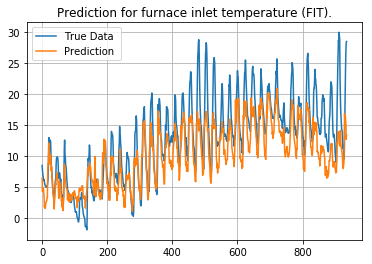

In [111]:
def plot_results(predicted_data, true_data):
    f, ax = plt.subplots(figsize = (6,4))
    plt.plot(np.array(true_data), label='True Data ')
    plt.plot(predicted_data, label='Prediction')
    plt.title("Prediction for furnace inlet temperature (FIT).")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_results(one_step,air_test_y)

In [113]:
#mse_train= np.mean((y_train-pred_train)**2)

mse =np.mean((np.subtract(air_test_y, one_step))**2)
print("Mean squared error", mse)

Mean squared error 16.399917260648134


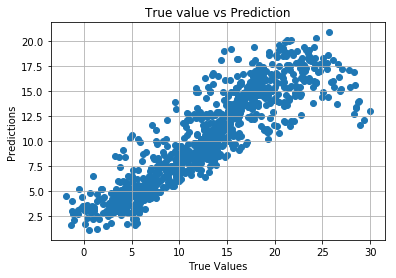

In [116]:
#True value vs prediction
f, ax = plt.subplots(figsize = (6,4))
plt.scatter(air_test_y, one_step)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True value vs Prediction")
plt.grid(True)

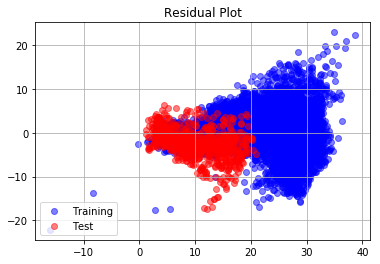

In [118]:
#Residual Plot
#min_limit= min(min(air_test_y),min(one_step))
#max_limit = max(max(air_test_y),max(one_step))
f, ax = plt.subplots(figsize = (6,4))
train_res = plt.scatter(one_step_train,(one_step_train-np.array(air_train_y)),c='b',alpha=0.5)
test_res = plt.scatter(one_step,(one_step-np.array((air_test_y))),c='r',alpha=0.5)
#plt.hlines(y=0,xmin=min_limit,xmax=max_limit)
plt.legend((train_res,test_res),('Training','Test'),loc='lower left')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [121]:
#Statistical Results
print("TEST RESULTS")

test_mae_linear = np.mean(np.abs(air_test_y - one_step))
test_mae_baseline = np.mean(np.abs(air_test_y - np.median(air_train_y))) ## training median as baseline predictor
print("Test Mean Squared Error Baseline :", round(test_mae_baseline, 3))
print("Test Mean Absolute Error :", round(test_mae_linear,3))


#Mean Squared Error
mse =np.mean((np.subtract(air_test_y, one_step))**2)
print("Test Mean Squared Error", mse)

#median absolute percentage error (MdAPE)
print('One-step-ahead median absolute percentage error (MdAPE) for test date = ',
      np.median(np.abs(np.subtract(air_test_y, one_step)/air_test_y)))

TEST RESULTS
Test Mean Squared Error Baseline : 7.91
Test Mean Absolute Error : 3.184
Test Mean Squared Error 16.399917260648134
One-step-ahead median absolute percentage error (MdAPE) for test date =  0.2350703513268197


### DELETE ENDPOINT

In [123]:
#delete endpoint
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: linear-learner-2018-12-18-01-41-51-584
